# Исследование данных сайта MetalStorm на предмет закономерностей

### Эта работа посвящена исследованию различных данных о метал-группах с сайта Metalstorm. Задача, которая стояла передо мной в рамках данного мини-проекта, заключалась в том, чтобы получить как можно больше статистических выкладок по теме и расширить свое понимание металической сцены.

### Выборка, взятая мною для исследования, составляет 500 первых по популярности групп на сайте.

*Презентация с результатами работы: https://drive.google.com/file/d/1Bsk_rAyBcIC-7G7L9K1QQZj6x2_-HCAh/view?usp=sharing*

### Часть 1: получение данных

Чтобы получить в свое распоряжение данные, необходимые для исследования, я использовал библиотеки requests и BeautifulSoup. С их помощью я распарсил таблицу MetalStorm-а и пересобрал ее в виде pandas DataFrame.

In [1]:
import requests
# from bs4 import BeautifulSoup
# import lxml
# from time import sleep

In [2]:
#band_name = []
#genres = []
#formed_in = []
#from_country = []
#count = 0
#t = '\n'
#headers =  {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/789.36 (KHTML, like Gecko) Chrome/101.0.0.0 Safari/532.36"}
#link_list = []
#for n in range(1,11):
#    sleep(5)
#    url = f'https://metalstorm.net/bands/index.php?b_sortby=&b_where=&b_what=&page={n}'
#    response = requests.get(url, headers=headers)
#    soup = BeautifulSoup(response.text, 'lxml')
#    table = soup.find('table',class_="table table-striped")
#    all_in = table.find_all('tr')
#    for i in all_in[1:]:
#        sleep(5)
#        name = i.find('b').text
#        year = i.find('div',class_="visible-xs mini dark").text
#        y = i.find_all('td',class_="mini-on-xs")
#        genre = []
#        base_genre = y[0]
#        step_genre = base_genre.find_all('a')
#        for p in step_genre:
#           genre.append(p.get_text())
#    country = y[1].text.strip()
#       genres.append(genre)
#       from_country.append(country)
#       formed_in.append(year)
#       band_name.append(name)
#       count += 1
#       print(f'{count}/500')
#       print(band_name[-1])
#pint('ready')

In [3]:
import pandas as pd
#df = pd.DataFrame({
#    'band_name' : band_name,
#    'country' : from_country,
#    'formed-split' : formed_in,
#    'genres' : [', '.join(w) for w in genres]
#})
#df.to_csv('Metal_bands_list_2')

In [4]:
import numpy as np

In [5]:
#Доступ к файлу по ссылке:
#from io import BytesIO
#spreadsheet_id = '1tFN3VENBCn6kmwhjwFJ2UAplntXQYP10M1lFKGg-fmo'
#reserve_copy = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
#r = requests.get(reserve_copy)
#df = pd.read_csv(BytesIO(r.content))
#df = df.drop('Unnamed: 0',axis=1)

In [6]:
df = pd.read_csv('Metal_bands_list_2',sep=',',header=0,index_col=None)
df = df.drop('Unnamed: 0',axis=1)

Результатом данного этапа работы стала следующая таблица, в которой фигурировали название групп, страна их происхождения, год образования и жанры, в которых они играют:

In [7]:
df.style

,band_name,country,formed-split,genres
0,Iron Maiden,United Kingdom,1975-,"New wave of British heavy, Heavy"
1,Opeth,Sweden,1990-,"Extreme progressive, Progressive, Progressive rock"
2,Metallica,USA,1981-,"Heavy, Bay Area thrash"
3,Megadeth,USA,1983-,"Thrash, Heavy, Hard rock"
4,Amon Amarth,Sweden,1988-,Melodic death
5,Slayer,USA,1981-2019,Thrash
6,Death,USA,1983-2001,"Progressive death, Death, Progressive thrash"
7,Black Sabbath,United Kingdom,1968-2017,"Doom, Heavy, Hard rock"
8,Dream Theater,USA,1985-,Progressive
9,Judas Priest,United Kingdom,1969-,"Heavy, Hard rock"


### Часть 2: предобработка

После того, как в моем распоряжении оказалась готовая таблица с информацией о группах, мне необходимо было обработать ее и подготовить данные для анализа.

Для начала я исправил столбец с годом образования группы. Я убрал лишние дефисы, переместил год распада групп в отдельную колонку и изменил тип данных со строкового на числовой. 

In [8]:
split = []
def numbers(x):
    if len(x) == 5:
        split.append('-')
        return x[:4]
    if len(x) > 5:
        split.append(x[5:])
        return x[:4]
df['formed-split'] = df['formed-split'].apply(numbers)

In [9]:
df['split'] = split
df = df.rename(columns={'formed-split' : 'formed'})

In [10]:
df['formed'] = pd.to_numeric(df['formed'])
df['split'] = pd.to_numeric(df['split'],errors='coerce')
df['split'] = df['split'].fillna('-')

In [11]:
def to_int(x):
    if x != '-':
        return int(x)
    else:
        return '-'

In [12]:
df['split'] = df['split'].apply(to_int)

In [13]:
df.head()

,band_name,country,formed,genres,split
0,Iron Maiden,United Kingdom,1975,"New wave of British heavy, Heavy",-
1,Opeth,Sweden,1990,"Extreme progressive, Progressive, Progressive...",-
2,Metallica,USA,1981,"Heavy, Bay Area thrash",-
3,Megadeth,USA,1983,"Thrash, Heavy, Hard rock",-
4,Amon Amarth,Sweden,1988,Melodic death,-


Затем я обратил внимание на проблему со столбцом жанров: большинство групп имело в своем распоряжении 2-3 разных жанра, которые, в свою очередь, являлись составными и включали основное направление (death, black, folk и др) и уточняющее слово-субжанр (melodic, atmospheric, progressive и др). Такое положение дел крайне сильно затрудняло анализ, поэтому я решил разделить все жанры на две отдельные таблицы по указанному выше признаку. 

In [14]:
genre_lib_base = []
genre_lib = []
g = df['genres'].unique()
for i in g:
    genre_lib_base.append(i.split(', '))
for lis in genre_lib_base:
    for genre in lis:
        genre_lib.append(genre)
genre_lib = pd.Series(genre_lib)

In [15]:
genre_lib = genre_lib.str.lower()
def xstrip(x):
    return x.strip()
genre_lib = genre_lib.apply(xstrip)

Сперва, я добился того, чтобы привести все названия жанров к единому виду:

In [16]:
genre_lib = genre_lib.drop_duplicates()
genre_lib.head()

0    new wave of british heavy
1                        heavy
2          extreme progressive
3                  progressive
4             progressive rock
dtype: object

Затем удалил дубликаты и исправленные жанры разделил на две таблицы:

In [17]:
main_genre_lib = []
sub_genre_lib = []
def genre_separation(x):
    text = x.split(' ')
    main_genre_lib.append(text[-1])
    sub = text[:-1]
    sub_genre_lib.append(' '.join(sub))
                         
genre_lib.apply(genre_separation)

main_genre_lib = pd.Series(main_genre_lib)
main_genre_lib = main_genre_lib.drop_duplicates().reset_index(drop=True)

sub_genre_lib = pd.Series(sub_genre_lib)
sub_genre_lib = sub_genre_lib.drop_duplicates().reset_index(drop=True)
sub_genre_lib = sub_genre_lib.replace('',np.nan)
sub_genre_lib = sub_genre_lib.dropna().reset_index(drop=True)

In [18]:
main_genre_lib = pd.DataFrame(main_genre_lib)
main_genre_lib = main_genre_lib.rename(columns = {0 : 'main_genres'})
main_genre_lib['count'] = 0

In [19]:
sub_genre_lib = pd.DataFrame(sub_genre_lib)
sub_genre_lib = sub_genre_lib.rename(columns = {0 : 'sub_genres'})
sub_genre_lib['count'] = 0

In [20]:
def genre_density(x):
    text = x.lower()
    lis = text.split(',')
    for i in range(len(lis)):
        lis[i] = xstrip(lis[i])
    for step in lis:
        keys = step.split(' ')
        main = keys[-1]
        sub = ' '.join(keys[:-1])
        for chek_m in main_genre_lib['main_genres']:
            if chek_m == main:
                main_genre_lib.loc[main_genre_lib['main_genres'] == chek_m,'count'] += 1
        for chek_s in sub_genre_lib['sub_genres']:
            if chek_s == sub:
                sub_genre_lib.loc[sub_genre_lib['sub_genres'] == chek_s,'count'] += 1

if main_genre_lib['count'].sum() == 0:
    df['genres'].apply(genre_density)
main_genre_lib = main_genre_lib.sort_values(by='count',ascending=False).reset_index(drop=True)

In [21]:
sub_genre_lib = sub_genre_lib.sort_values(by='count',ascending=False).reset_index(drop=True)

Исправил очевидные ошибки, высчитал количество появлений жанров у групп и их процентное соотношение:

In [22]:
main_genre_lib['part(%)'] = np.around(main_genre_lib['count'] / sum(main_genre_lib['count']),4)*100
sub_genre_lib['part(%)'] = np.around(sub_genre_lib['count'] / sum(sub_genre_lib['count']),4)*100

In [23]:
main_genre_lib = main_genre_lib.drop(index=20).reset_index(drop=True)

main_genre_lib.loc[37,'main_genres'] = "death 'n' roll"
sub_genre_lib = sub_genre_lib.drop(46,axis=0).reset_index(drop=True)

main_genre_lib.loc[34,'main_genres'] = "synth wave"
sub_genre_lib = sub_genre_lib.drop(38,axis=0).reset_index(drop=True)

main_genre_lib = main_genre_lib.drop(32,axis=0).reset_index(drop=True)

Получил финальные версии таблиц:

In [24]:
main_genre_lib.head()

,main_genres,count,part(%)
0,death,148,16.80
1,black,94,10.67
2,thrash,67,7.60
3,heavy,66,7.49
4,rock,65,7.38


In [25]:
sub_genre_lib.head()

,sub_genres,count,part(%)
0,melodic,56,15.18
1,progressive,43,11.65
2,symphonic,34,9.21
3,technical,27,7.32
4,hard,27,7.32


### Часть 3: общее исследование и визуализация

Для наглядности, я решил визуализировать данные из полученных таблиц в виде круговых диаграмм.

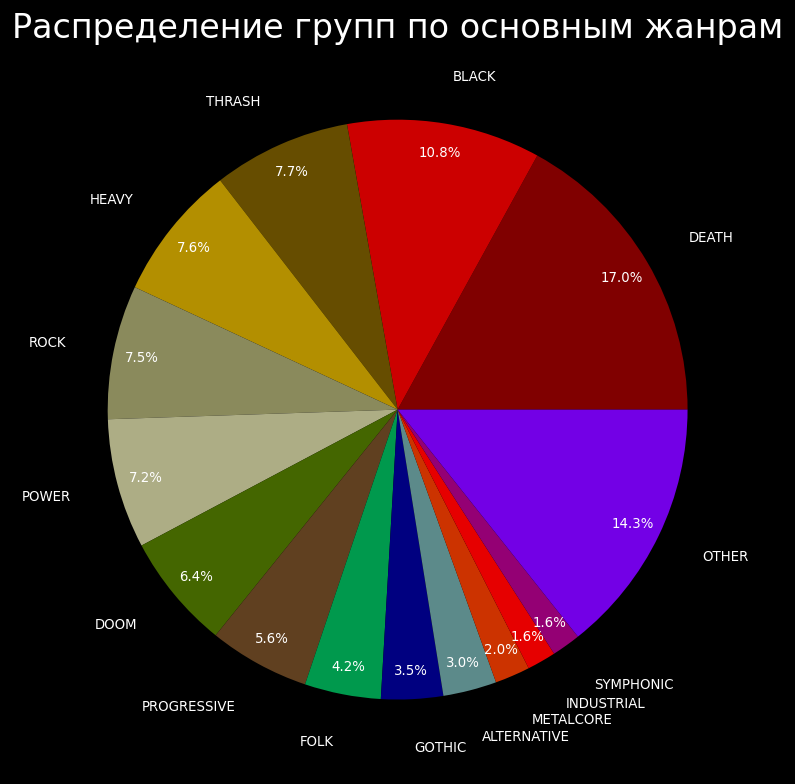

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('dark_background')

main_copy= main_genre_lib.copy()
main_copy.loc[main_copy['part(%)'] < 1.5,'main_genres'] = 'other'
summ = main_copy.loc[main_copy['main_genres'] == 'other','count'].sum()
part = main_copy.loc[main_copy['main_genres'] == 'other','part(%)'].sum()
main_copy = main_copy[:15]
main_copy.loc[main_copy['main_genres'] == 'other','count'] = summ
main_copy.loc[main_copy['main_genres'] == 'other','part(%)'] = part
main_copy

labels = main_copy['main_genres'].str.upper()
sizes = main_copy['part(%)']
colors = ['#800000','#cc0000','#664d00','#b38f00','#8a8a5c','#adad85','#446600','#604020','#00994d','#000080','#5c8a8a','#cc3300','#e60000','#940074','#7300e6']
plt.figure(figsize=(9,8),dpi=120)
plt.title('Распределение групп по основным жанрам',fontsize=20)
plt.pie(sizes, labels=labels, autopct='%1.1f%%',textprops={'fontsize': 8},colors=colors,labeldistance=1.165,pctdistance=0.9)
plt.show() 

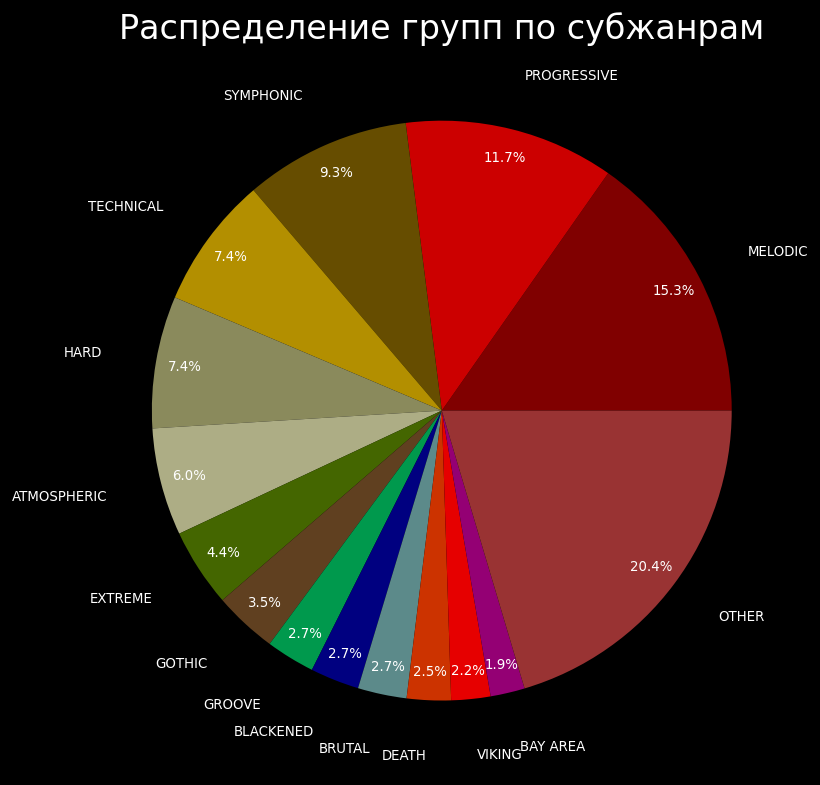

In [27]:
sub_copy= sub_genre_lib.copy()
sub_copy.loc[sub_copy['part(%)'] < 1.5,'sub_genres'] = 'other'
summ_s = sub_copy.loc[sub_copy['sub_genres'] == 'other','count'].sum()
part_s = sub_copy.loc[sub_copy['sub_genres'] == 'other','part(%)'].sum()
sub_copy = sub_copy[:15]
sub_copy.loc[sub_copy['sub_genres'] == 'other','count'] = summ_s
sub_copy.loc[sub_copy['sub_genres'] == 'other','part(%)'] = part_s

labels = sub_copy['sub_genres'].str.upper()
sizes = sub_copy['part(%)']
colors = ['#800000','#cc0000','#664d00','#b38f00','#8a8a5c','#adad85','#446600','#604020','#00994d','#000080','#5c8a8a','#cc3300','#e60000','#940074','#993333','#e6004c','#333300','#9900cc','#7300e6']
plt.figure(figsize=(9,8),dpi=120)
plt.title('Распределение групп по субжанрам',fontsize=20)
plt.pie(sizes, labels=labels, autopct='%1.1f%%',textprops={'fontsize': 8},colors=colors,labeldistance=1.19,pctdistance=0.9)
plt.show() 

В дополнение к жанрам, я решил также обработать года и страны и составить для них наглядное визуальное представление. 

In [28]:
years = pd.DataFrame(df.value_counts('formed'))
years['year'] = years.index
years_2 = years.reset_index(drop=True)
years_2 = years_2.rename(columns = {0 : 'number'})
years_2 = years_2.sort_values(by='year').reset_index(drop=True)
years_2.head()

,number,year
0,1,1964
1,1,1965
2,5,1968
3,4,1969
4,3,1972


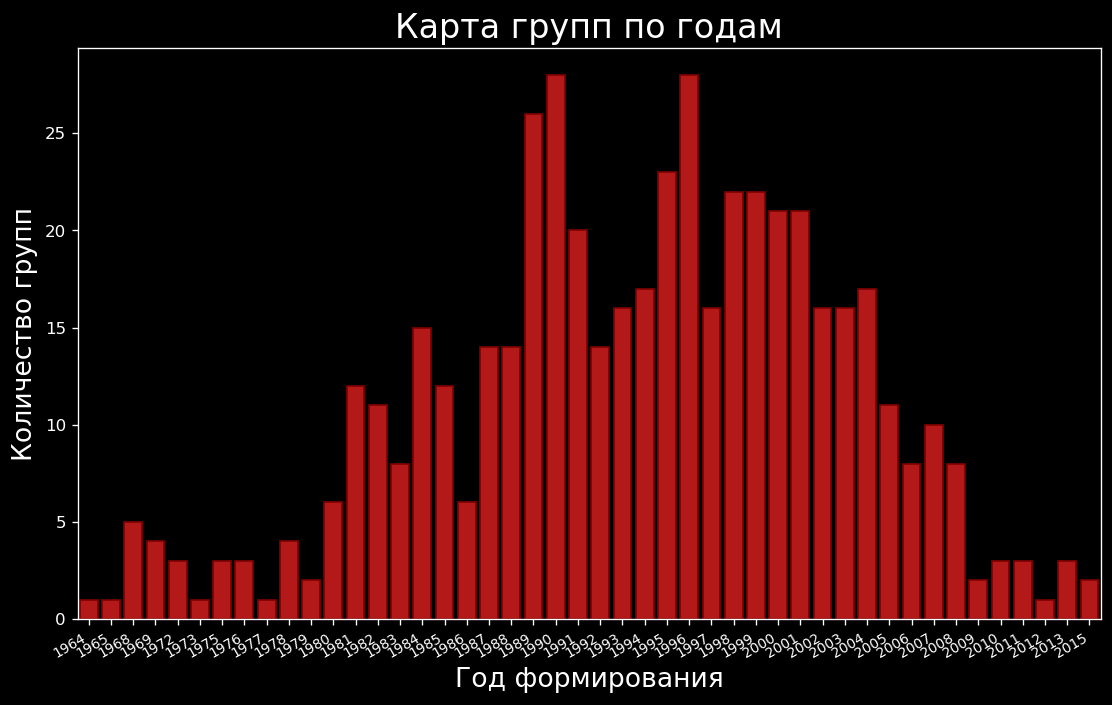

In [29]:
fig, ax = plt.subplots(figsize=(11,7),dpi=120)
plt.title('Карта групп по годам',fontsize=20)
sns.barplot(x=years_2['year'],y=years_2['number'],color='#cc0000',edgecolor = '#800000')
plt.xticks(fontsize=8.3)
plt.xlabel('Год формирования',fontsize=16)
plt.ylabel('Количество групп',fontsize=16)
ax.xaxis_date()
fig.autofmt_xdate()
plt.show()

In [30]:
country_map = pd.DataFrame(df.groupby('country')['band_name'].count().sort_values(ascending=False))
country_map['country'] = country_map.index
country_map_2 = country_map.reset_index(drop=True)
country_map_2 = country_map_2.rename(columns = {'band_name' : 'number'})
country_map_2 = country_map_2.sort_values(by='number',ascending=False).reset_index(drop=True)
country_map_2.head()

,number,country
0,156,USA
1,62,Sweden
2,43,United Kingdom
3,42,Finland
4,42,Germany


In [31]:
extra_points = []
def country_fix_1(row):
    c = row['country']
    n = row['number']
    box = c.split(', ')
    if len(box) > 1:
        for i in box:
            for t in range(n):
                extra_points.append(i)
        
    return extra_points
       
extract_points = country_map_2.apply(country_fix_1,axis=1)
extract_points_2 = extract_points[0]

В случае со странами, необходимо было дополнительно обработать те группы, которые включали участников из разных государств и, как следствие, некорректно отображались в таблице.

In [32]:
mark = 0
if mark == 0:
    mark = 1
    for i in extract_points_2:
        country_map_2.loc[country_map_2['country'] == i,'number'] += 1

    for c in range(len(country_map_2['country'])):
        box = country_map_2['country'][c].split(', ')
        if len(box) > 1:
            country_map_2 = country_map_2.drop(c,axis=0)

In [33]:
country_map_2 = country_map_2.sort_values(by='number',ascending=False)
country_map_copy = country_map_2.copy()

In [34]:
s = country_map_copy.loc[country_map_copy['number'] < 3,'number'].sum()
country_map_copy = country_map_copy.loc[country_map_copy['number'] >= 3]
other = [s,'other']
country_map_copy.loc[len(country_map_copy)] = other
country_map_copy.head()

,number,country
0,163,USA
1,63,Sweden
2,47,United Kingdom
3,42,Finland
4,42,Germany


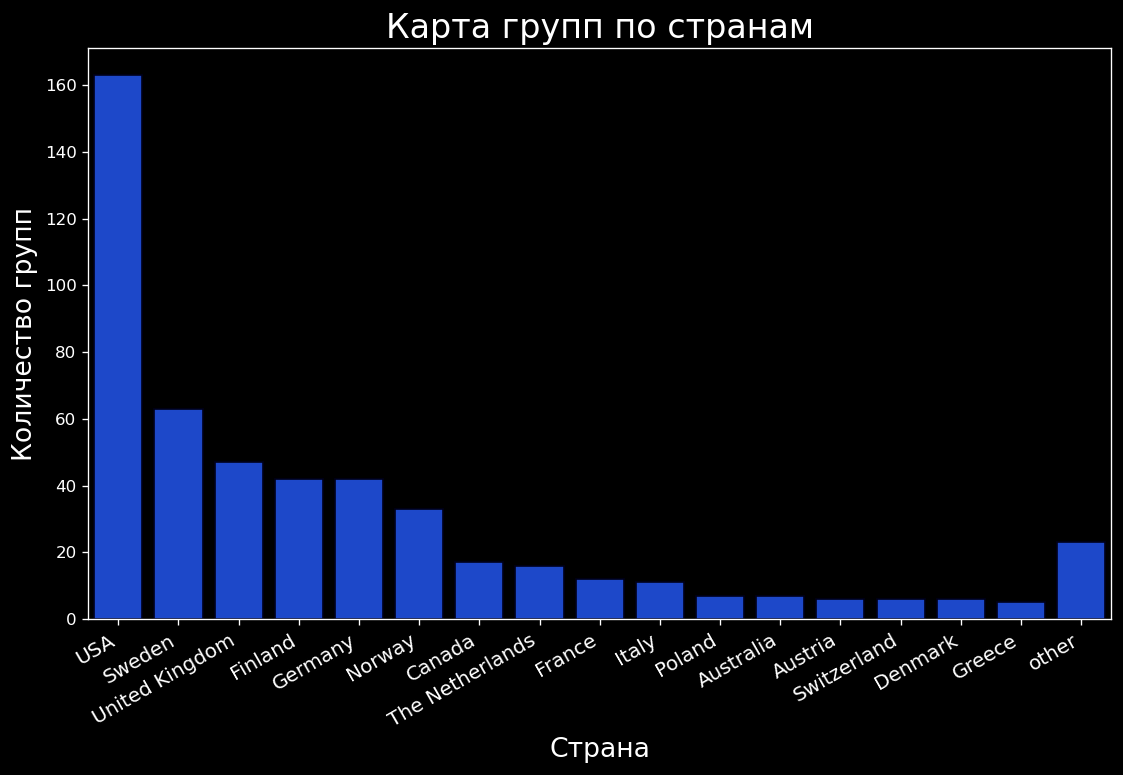

In [35]:
fig, ax = plt.subplots(figsize=(11,7),dpi=120)
plt.title('Карта групп по странам',fontsize=20)
sns.barplot(x=country_map_copy['country'],y=country_map_copy['number'],color='#0039e6',edgecolor = '#00001a')
plt.xticks(fontsize=12)
plt.xlabel('Страна',fontsize=16)
plt.ylabel('Количество групп',fontsize=16)
ax.xaxis_date()
fig.autofmt_xdate()
plt.show()

Результатом этого этапа работы стали крайне любопытные графики, прекрасно отражающие картину истории металической музыки и ее современного положения.

### Часть 4: фильтрация и работа с таблицей

На следующем этапе я решил создать удобные инструменты поиска по таблице и ее фильтрации по заданному признаку.

Первым экспериментом была функция для поиска групп по входящему в их название слову и подсчету количества таких групп в целом. 

In [36]:
def count_words(x,word,count_word):
    chek_list = x.lower()
    if word in chek_list:
        count_word.append(x)
        
def count_words_use():  
    word = input()
    count_word = []
    df['band_name'].apply(count_words,word=word,count_word=count_word)
    print(count_word)
    print(len(count_word))   
    
count_words_use()

dark
['Dark Tranquillity', 'Darkthrone', 'Dark Funeral', 'Dark Moor', 'Dark Fortress', 'Dark Angel', 'Darkspace']
7


Вторая функция воспроизводила функционал поиска групп по жанру, уже имеющийся на изначальном сайте.

In [37]:
def find_genre(row,genre,bands):
    gen = row['genres'].lower()
    if genre in gen:
        bands.append(row['band_name'])

def find_genre_use():
    genre = input()
    bands = []
    df.apply(find_genre,genre=genre,bands=bands,axis=1)
    print(bands)
    
find_genre_use()

black
['Agalloch', 'Katatonia', 'Behemoth', 'Dimmu Borgir', 'Immortal', 'Enslaved', 'Emperor', 'Moonspell', 'Cradle Of Filth', 'Bathory', 'Burzum', 'Rotting Christ', 'Mayhem', 'Dissection', 'Alcest', 'Summoning', 'Darkthrone', 'Satyricon', 'Primordial', 'Mercyful Fate', 'Arcturus', 'Ulver', 'Marduk', 'Celtic Frost', 'Windir', 'Venom', 'Borknagar', 'Gorgoroth', 'Dark Funeral', 'Anaal Nathrakh', 'Shining', 'Drudkh', 'Samael', 'Watain', 'Mgła', 'Wolves In The Throne Room', 'Belphegor', 'Carach Angren', 'Deathspell Omega', 'Skeletonwitch', 'Sólstafir', 'Blut Aus Nord', 'Taake', 'Falkenbach', 'Melechesh', 'Graveworm', 'Woods Of Ypres', "Old Man's Child", 'Dark Fortress', 'Thy Catafalque', 'Carpathian Forest', 'Shade Empire', '1349', 'Vintersorg', 'Negură Bunget', 'Toxic Holocaust', 'Deafheaven', 'Sigh', 'Kvelertak', 'Saor', 'Caladan Brood', 'Tribulation', 'Kauan', 'Les Discrets', 'Naglfar', 'Necrophobic', 'Keep Of Kalessin', 'Månegarm', 'Inquisition', 'Thyrfing', 'Benighted', 'Catamenia', '

Третья функция добавляла новый фукционал, отсутствующий на сайте, и позволяла фильтровать группы по году их создания.

In [38]:
def find_year(row,year,year_bands):
    yer = row['formed']
    if year in str(yer):
        year_bands.append(row['band_name'])

def find_year_use():
    year = input()
    year_bands = []
    df.apply(find_year,year=year,year_bands=year_bands,axis=1)
    print(year_bands)

find_year_use()

1999
['Lamb Of God', 'Mastodon', 'Sabaton', 'Avantasia', 'DragonForce', 'Killswitch Engage', 'Avenged Sevenfold', 'Mors Principium Est', 'Before The Dawn', 'Demons & Wizards', 'Falconer', 'Shade Empire', 'Dream Evil', 'Toxic Holocaust', 'Dragonland', '3 Inches Of Blood', 'The Foreshadowing', 'Psycroptic', 'Luca Turilli', 'Darkspace', 'Halford', 'Battlelore']


Четвертая функция добавляла фильтрацию по стране создания.

In [39]:
def find_country(row,country,country_bands):
    con = str(row['country']).lower()
    if country.lower() in con:
        country_bands.append(row['band_name'])

def find_country_use():
    country = input()
    country_bands = []
    df.apply(find_country,country=country,country_bands=country_bands,axis=1)
    print(country_bands)
    
find_country_use()

iceland
['Sólstafir']


Наконец, последняя функция позволяла просто вывести строку таблицы с информацией о группе по ее названию.

In [40]:
def band_info():
    band = input()
    return df.loc[df['band_name'].str.lower() == band.lower()]

band_info()

children of bodom


,band_name,country,formed,genres,split
11,Children Of Bodom,Finland,1993,Extreme power,2019


### Часть 5: исследование жанров по странам

Важной глобальной задачей, которую я ставил перед собой, было выяснить, есть ли существенная разница между жанрами, наиболее распространенными в разных странах.

Для проведения этого исследования я создал пустой DataFrame и каскад из функций, заполняющих таблицу тремя самыми распространенными в каждой из стран жанрами. При этом я создал разные функции для исследования по тому, что ранее было названо "основными жанрами" (main genres), и по полноценным жанрам (комбинации субжанра и жанра). Это позволило получить наиболее полное представление о сцене каждого из государств. 

In [41]:
gbc_list = pd.DataFrame(
    columns = ['country','band','genres']
)

In [42]:
def global_genre_by_country_density(row,country):
    con = str(row['country'])
    gen = row['genres']
    ban = row['band_name']
    if country in con:
        text = gen.lower().split(',')
        for i in range(len(text)):
            text[i] = xstrip(text[i]) 
        for step in text:
            num = len(gbc_list_copy)
            gbc_list_copy.loc[num,'country'] = country
            gbc_list_copy.loc[num,'band'] = ban
            gbc_list_copy.loc[num,'genres'] = step.split(' ')[-1]

def exact_genre_by_country_density(row,country):
    con = str(row['country'])
    gen = row['genres']
    ban = row['band_name']
    if country in con:
        text = gen.lower().split(',')
        for i in range(len(text)):
            text[i] = xstrip(text[i]) 
        for step in text:
            num = len(gbc_list_copy)
            gbc_list_copy.loc[num,'country'] = country
            gbc_list_copy.loc[num,'band'] = ban
            gbc_list_copy.loc[num,'genres'] = step
            
def find_genres_by_country(country,typ='global'):
    if typ == 'global':
        df.apply(global_genre_by_country_density,country=country,axis=1)
        gbc = pd.DataFrame(gbc_list_copy['genres'].value_counts())
        gbc['genre'] = gbc.index
        gbc = gbc.rename(columns = {'genres' : 'number'})
        gbc = gbc.reset_index(drop=True)
        gbc['part(%)'] = np.around(gbc['number'] / sum(gbc['number'] ),3) * 100
        gbc['country'] =  country
        return gbc.head(3)
    elif typ == 'exact':
        df.apply(exact_genre_by_country_density,country=country,axis=1)
        gbc = pd.DataFrame(gbc_list_copy['genres'].value_counts())
        gbc['genre'] = gbc.index
        gbc = gbc.rename(columns = {'genres' : 'number'})
        gbc = gbc.reset_index(drop=True)
        gbc['part(%)'] = np.around(gbc['number'] / sum(gbc['number'] ),3) * 100
        gbc['country'] =  country
        return gbc.head(3)
    else:
        return 'error'

На промежуточном этапе я получил две таблицы, удовлетворяющие заданным требованиям:

In [43]:
total_info = pd.DataFrame(columns = ['number','genre','part(%)','country'])
country_list = list(country_map_2['country'])
for block in country_list:
    gbc_list_copy = gbc_list.copy()
    head = find_genres_by_country(block)
    for r in range(len(head)):
        n = head.loc[r,'number']
        g = head.loc[r,'genre']
        p = head.loc[r,'part(%)']
        c = head.loc[r,'country']
        l = len(total_info)
        total_info.loc[l,'number'] = n
        total_info.loc[l,'genre'] = g
        total_info.loc[l,'part(%)'] = p
        total_info.loc[l,'country'] = c
total_info.head(9)

,number,genre,part(%),country
0,44,death,15.2,USA
1,42,thrash,14.5,USA
2,30,rock,10.4,USA
3,24,death,22.0,Sweden
4,14,black,12.8,Sweden
5,12,doom,11.0,Sweden
6,17,heavy,20.2,United Kingdom
7,15,rock,17.9,United Kingdom
8,11,doom,13.1,United Kingdom


In [44]:
total_info_ex = pd.DataFrame(columns = ['number','genre','part(%)','country'])
country_list = list(country_map_2['country'])
for block in country_list:
    gbc_list_copy = gbc_list.copy()
    head = find_genres_by_country(block,typ='exact')
    for r in range(len(head)):
        n = head.loc[r,'number']
        g = head.loc[r,'genre']
        p = head.loc[r,'part(%)']
        c = head.loc[r,'country']
        l = len(total_info_ex)
        total_info_ex.loc[l,'number'] = n
        total_info_ex.loc[l,'genre'] = g
        total_info_ex.loc[l,'part(%)'] = p
        total_info_ex.loc[l,'country'] = c
total_info_ex.head(9)

,number,genre,part(%),country
0,26,heavy,9.0,USA
1,18,alternative,6.2,USA
2,16,thrash,5.5,USA
3,12,death,11.0,Sweden
4,8,melodic death,7.3,Sweden
5,8,progressive,7.3,Sweden
6,13,heavy,15.5,United Kingdom
7,8,hard rock,9.5,United Kingdom
8,5,doom,6.0,United Kingdom


После этого осталось лишь добавить визуализацию и представить ее в наглядной форме.

In [45]:
def ti_graph(country,typ='global'):
    if typ == 'exact':
        ti_ = total_info_ex
    else:
        ti_ = total_info
    ti = ti_.loc[ti_['country'] == country]
    colors = ['#e60000','#608000','#ff6600']
    plt.figure(figsize=(4,6),dpi=120)
    sns.barplot(data = ti, x = "country", y= "part(%)", hue= "genre",palette=colors,edgecolor='#8c8c8c')
    plt.xlabel('Страна',fontsize=12)
    plt.ylabel('Самые популярные жанры (%)',fontsize=12)
    plt.title('Самые популярные жанры по стране',fontsize=14)
    plt.show()
    display(ti)

In [46]:
def gbc_final_info_row(c,typ='global'):
    gbc_list_copy = gbc_list.copy()
    if typ == 'exact':
        ti_graph(country=c,typ='exact')
    else:
        ti_graph(country=c,typ='global')

Я использовал обе функции на первые 10 стран по количеству групп: 

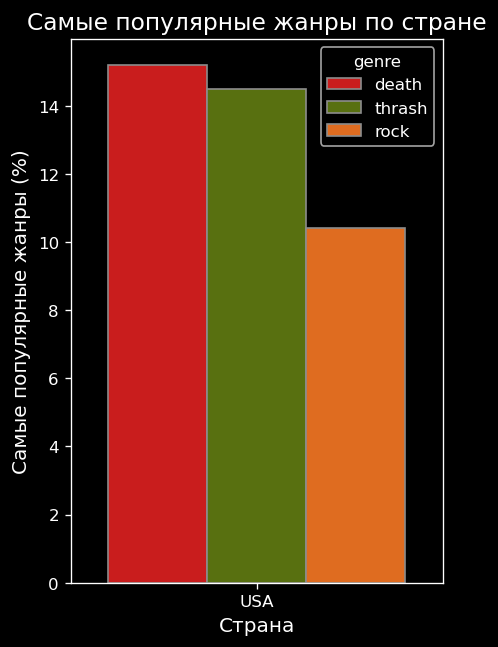

,number,genre,part(%),country
0,44,death,15.2,USA
1,42,thrash,14.5,USA
2,30,rock,10.4,USA


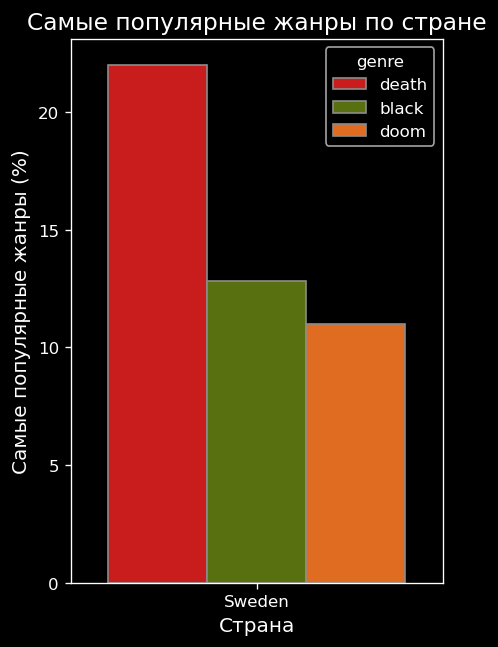

,number,genre,part(%),country
3,24,death,22.0,Sweden
4,14,black,12.8,Sweden
5,12,doom,11.0,Sweden


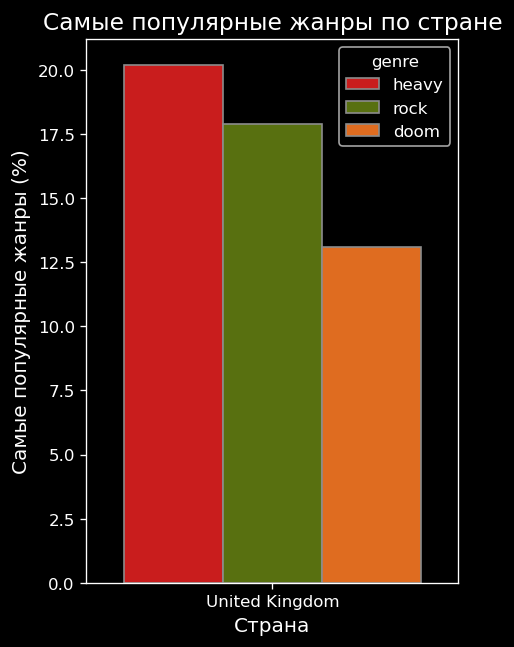

,number,genre,part(%),country
6,17,heavy,20.2,United Kingdom
7,15,rock,17.9,United Kingdom
8,11,doom,13.1,United Kingdom


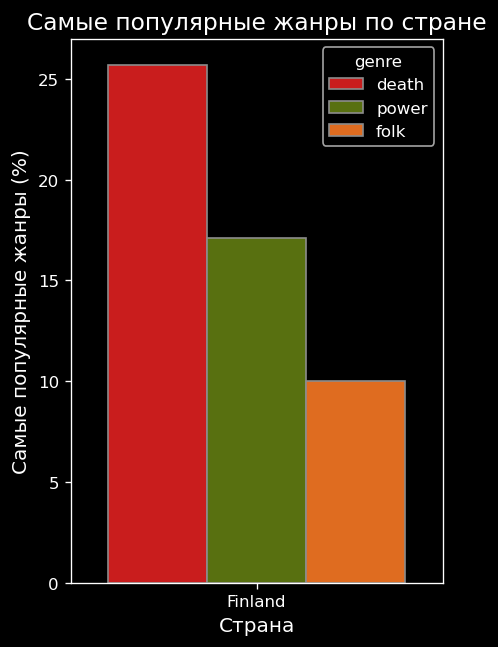

,number,genre,part(%),country
9,18,death,25.7,Finland
10,12,power,17.1,Finland
11,7,folk,10.0,Finland


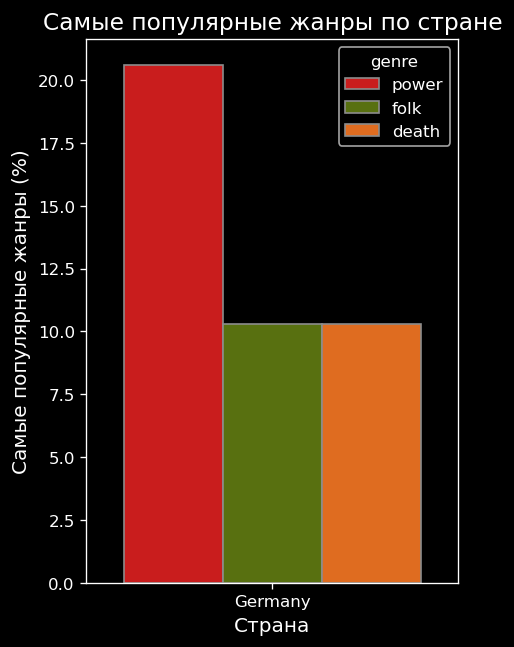

,number,genre,part(%),country
12,14,power,20.6,Germany
13,7,folk,10.3,Germany
14,7,death,10.3,Germany


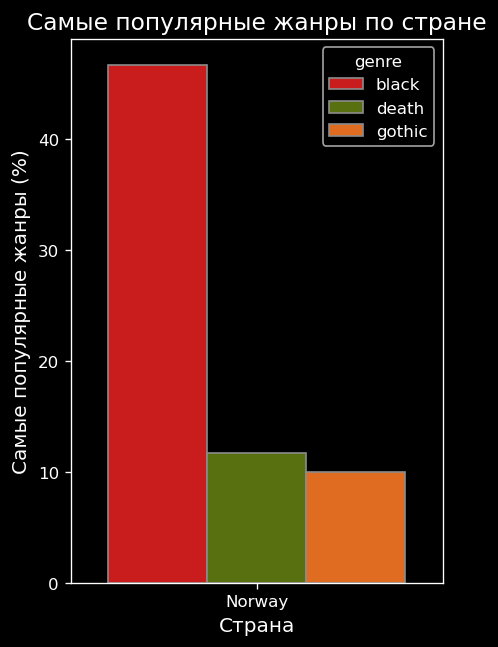

,number,genre,part(%),country
15,28,black,46.7,Norway
16,7,death,11.7,Norway
17,6,gothic,10.0,Norway


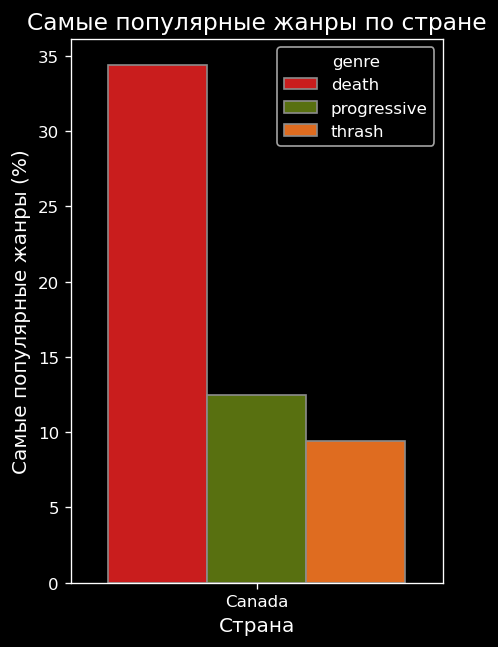

,number,genre,part(%),country
18,11,death,34.4,Canada
19,4,progressive,12.5,Canada
20,3,thrash,9.4,Canada


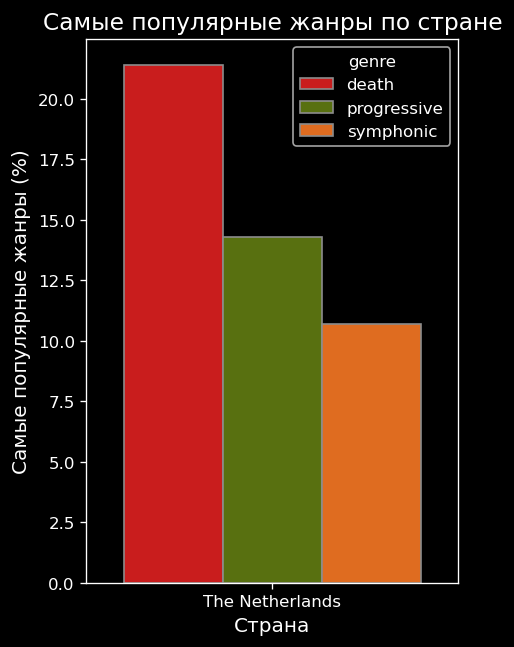

,number,genre,part(%),country
21,6,death,21.4,The Netherlands
22,4,progressive,14.3,The Netherlands
23,3,symphonic,10.7,The Netherlands


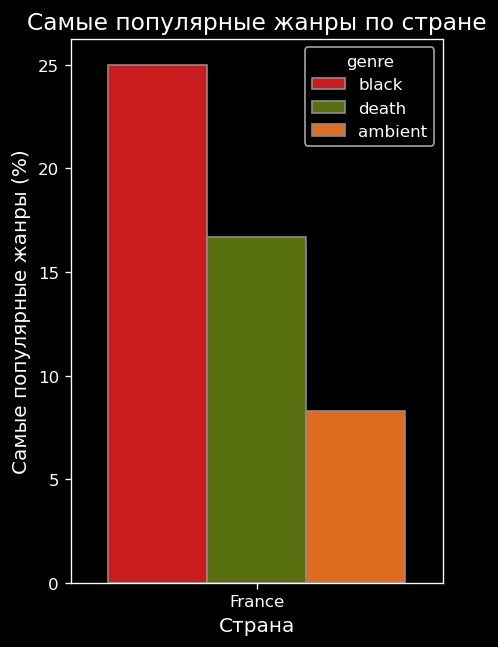

,number,genre,part(%),country
24,6,black,25.0,France
25,4,death,16.7,France
26,2,ambient,8.3,France


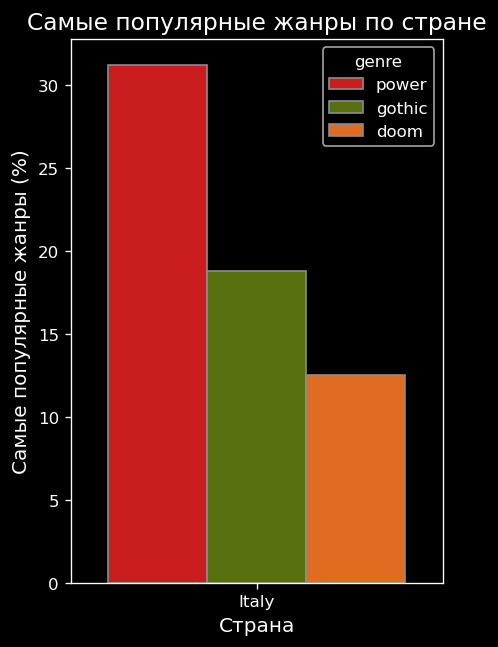

,number,genre,part(%),country
27,5,power,31.2,Italy
28,3,gothic,18.8,Italy
29,2,doom,12.5,Italy


In [47]:
for i in country_list[:10]:
    gbc_final_info_row(i,'global')

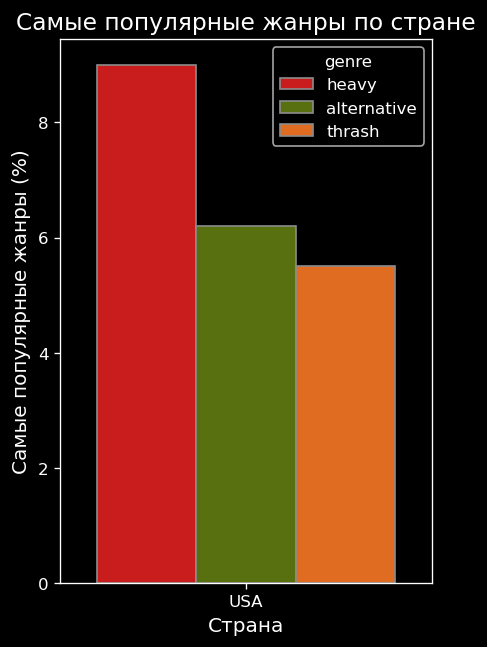

,number,genre,part(%),country
0,26,heavy,9.0,USA
1,18,alternative,6.2,USA
2,16,thrash,5.5,USA


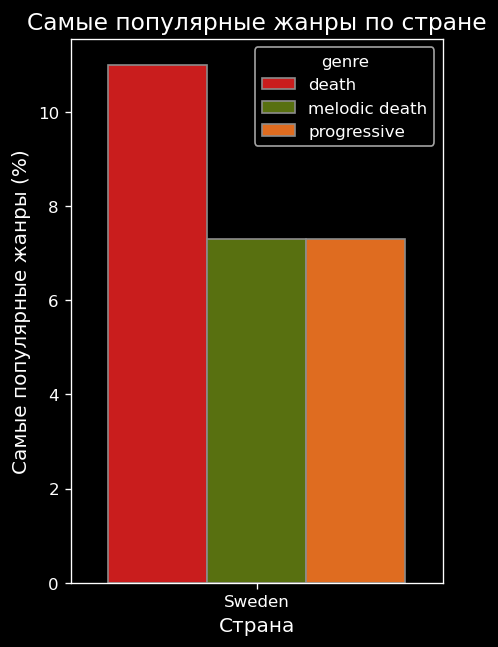

,number,genre,part(%),country
3,12,death,11.0,Sweden
4,8,melodic death,7.3,Sweden
5,8,progressive,7.3,Sweden


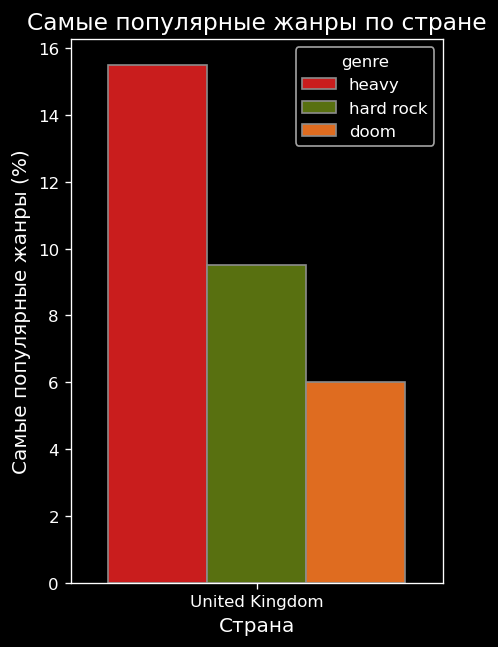

,number,genre,part(%),country
6,13,heavy,15.5,United Kingdom
7,8,hard rock,9.5,United Kingdom
8,5,doom,6.0,United Kingdom


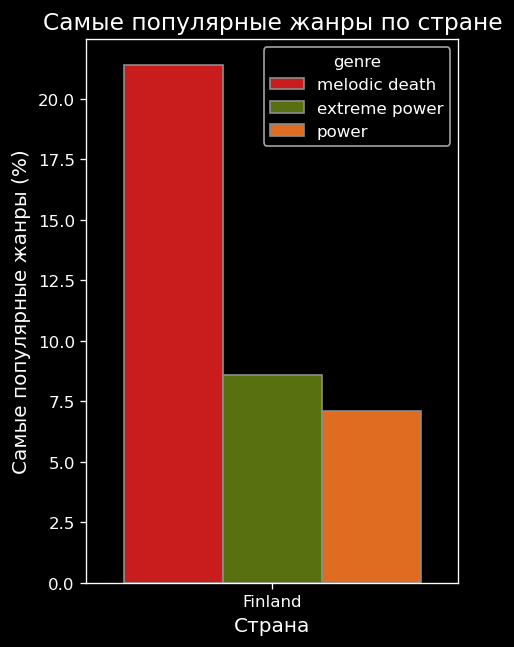

,number,genre,part(%),country
9,15,melodic death,21.4,Finland
10,6,extreme power,8.6,Finland
11,5,power,7.1,Finland


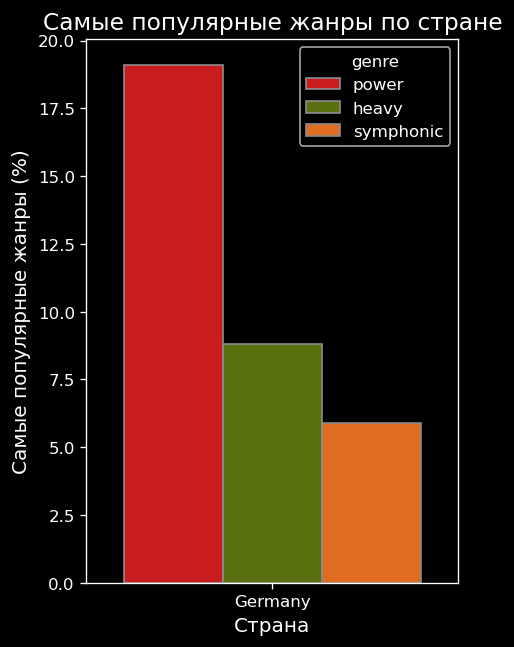

,number,genre,part(%),country
12,13,power,19.1,Germany
13,6,heavy,8.8,Germany
14,4,symphonic,5.9,Germany


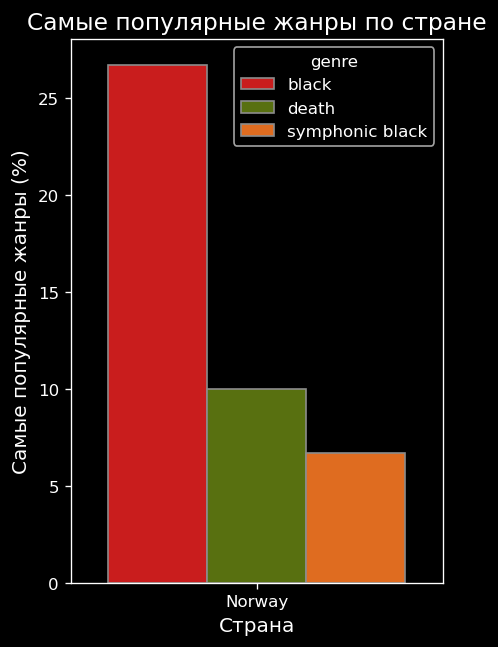

,number,genre,part(%),country
15,16,black,26.7,Norway
16,6,death,10.0,Norway
17,4,symphonic black,6.7,Norway


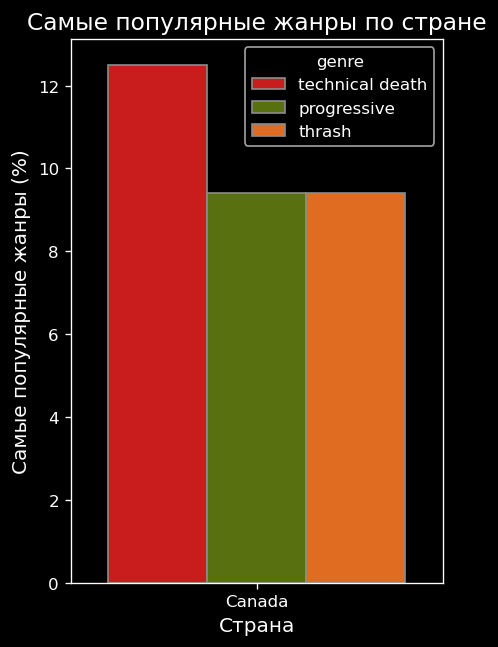

,number,genre,part(%),country
18,4,technical death,12.5,Canada
19,3,progressive,9.4,Canada
20,3,thrash,9.4,Canada


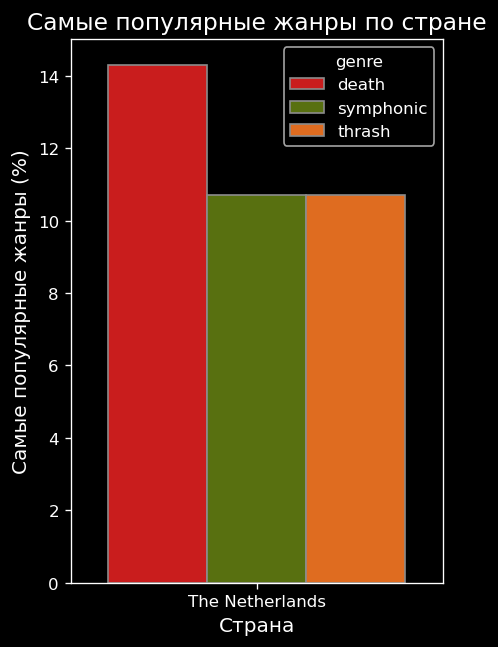

,number,genre,part(%),country
21,4,death,14.3,The Netherlands
22,3,symphonic,10.7,The Netherlands
23,3,thrash,10.7,The Netherlands


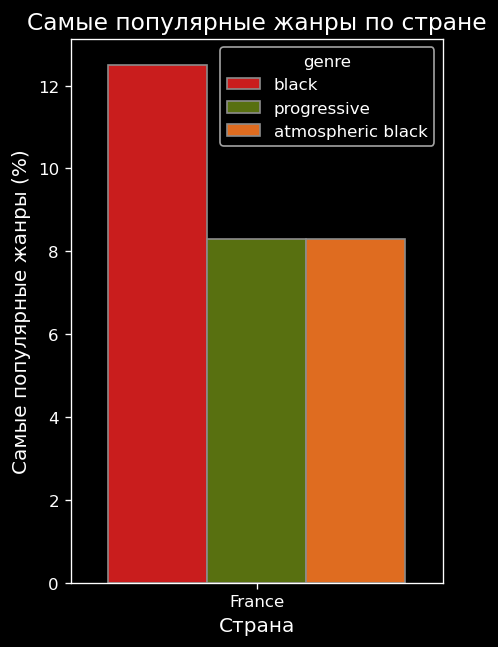

,number,genre,part(%),country
24,3,black,12.5,France
25,2,progressive,8.3,France
26,2,atmospheric black,8.3,France


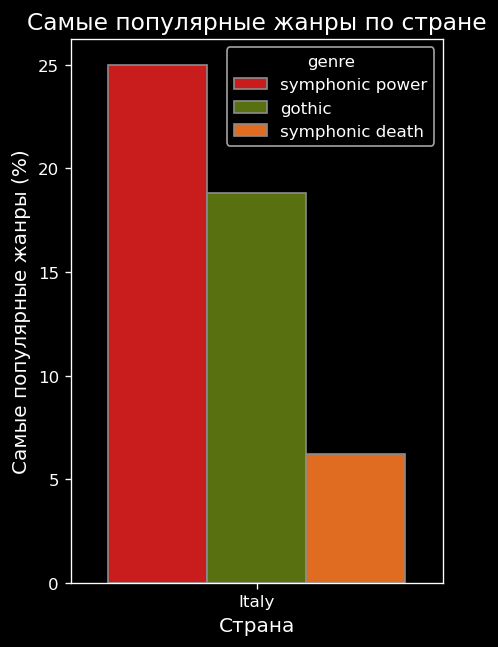

,number,genre,part(%),country
27,4,symphonic power,25.0,Italy
28,3,gothic,18.8,Italy
29,1,symphonic death,6.2,Italy


In [48]:
for i in country_list[:10]:
    gbc_final_info_row(i,'exact')

И добавил возможность применить их к любой другой стране, не попавшей в список:

In [49]:
def gbc_final_info_use():
    print('Country:')
    c = input()
    print('global or exact:')
    t = input()
    gbc_list_copy = gbc_list.copy()
    ti_graph(country=c,typ=t)

Country:
Finland
global or exact:
global


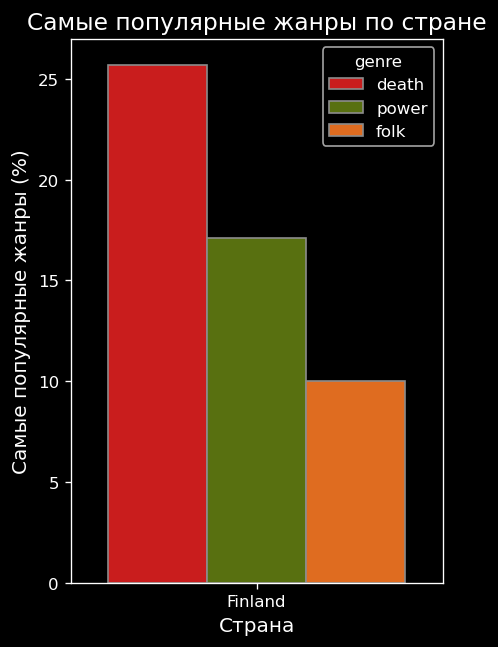

,number,genre,part(%),country
9,18,death,25.7,Finland
10,12,power,17.1,Finland
11,7,folk,10.0,Finland


In [51]:
gbc_final_info_use()

После этого исследование было окончено.

# Часть 6: Выводы

В рамках данной работы мною было проведено достаточно обширное исследование, которое значительно улучшило мое собственное понимание того, как устроена металическая сцена в контексте связи различных факторов отдельных групп между собой.


В этом мне помогли составленные в ходе работы таблицы: 

In [52]:
# Основная таблица
df.style

,band_name,country,formed,genres,split
0,Iron Maiden,United Kingdom,1975,"New wave of British heavy, Heavy",-
1,Opeth,Sweden,1990,"Extreme progressive, Progressive, Progressive rock",-
2,Metallica,USA,1981,"Heavy, Bay Area thrash",-
3,Megadeth,USA,1983,"Thrash, Heavy, Hard rock",-
4,Amon Amarth,Sweden,1988,Melodic death,-
5,Slayer,USA,1981,Thrash,2019
6,Death,USA,1983,"Progressive death, Death, Progressive thrash",2001
7,Black Sabbath,United Kingdom,1968,"Doom, Heavy, Hard rock",2017
8,Dream Theater,USA,1985,Progressive,-
9,Judas Priest,United Kingdom,1969,"Heavy, Hard rock",-


In [53]:
# Статистика по основным жанрам
main_genre_lib.style

,main_genres,count,part(%)
0,death,148,16.800000
1,black,94,10.670000
2,thrash,67,7.600000
3,heavy,66,7.490000
4,rock,65,7.380000
5,power,63,7.150000
6,doom,56,6.360000
7,progressive,49,5.560000
8,folk,37,4.200000
9,gothic,30,3.410000


In [54]:
# Статистика по субжанрам
sub_genre_lib.style

,sub_genres,count,part(%)
0,melodic,56,15.180000
1,progressive,43,11.650000
2,symphonic,34,9.210000
3,technical,27,7.320000
4,hard,27,7.320000
5,atmospheric,22,5.960000
6,extreme,16,4.340000
7,gothic,13,3.520000
8,groove,10,2.710000
9,blackened,10,2.710000


In [55]:
# Статистика по странам
country_map_2.reset_index(drop=True).style

,number,country
0,163,USA
1,63,Sweden
2,47,United Kingdom
3,42,Finland
4,42,Germany
5,33,Norway
6,17,Canada
7,16,The Netherlands
8,12,France
9,11,Italy


In [56]:
# Статистика по годам
years_2.style

,number,year
0,1,1964
1,1,1965
2,5,1968
3,4,1969
4,3,1972
5,1,1973
6,3,1975
7,3,1976
8,1,1977
9,4,1978


Созданные функции для фильтрации:

In [1]:
# Поиск по слову в названии
count_words_use()

NameError: name 'count_words_use' is not defined

In [ ]:
# Поиск по жанру
find_genre_use()

In [ ]:
# Поиск по стране
find_country_use()

In [ ]:
# Поиск по году создания
find_year_use()

In [ ]:
# Информация о группе
band_info()

А также все построенные в процессе работы графики.

### Выводы по результатам исследования:

1) Больше всего групп записывают музыку в жанрах death, black и thrash.  

2) Наиболее распространенными субжанрами являются melodic, progressive и symphonic.

3) Пик по количеству новых созданных групп был достигнут в 1990 и 1996 годах. В среднем, в девяностые этот показатель заметно выше, чем до и после них.

4) Однозначным лидером по количеству групп с огромным отрывом от всех конкурентов являются США. Следом на ними идут Швеция, Великобритания и Финляндия.

5) Жанры, популярные в этих странах, очень сильно разнятся. В США это преимущественно thrash metal, альтернативный и хард-рок, а также различные вариации death metal-а. В Швеции это death и melodic death с примесью doom и progressive жанров. В Великобритании явными фаворитами являются heavy metal и hard rock, однако также имеет место doom. Финские же группы отдают предпочтение смежным жанрам melodic death и extrim power, а также обычному power и folk. 

6) Среди групп внутри имеющейся выборки слово "dark" встречалось в названии 7 раз, слова "death" и "black" - 6 раз. 

*Результаты исследования наглядно представлены в презентации:*

https://drive.google.com/file/d/1Bsk_rAyBcIC-7G7L9K1QQZj6x2_-HCAh/view?usp=sharing